# CNN Classifier on cifar-100 (Best Model)

### Load google drive to refer to dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load required libraries

In [2]:
# %tensorflow_version 1.x
from __future__ import print_function

import pickle
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
import collections
import xgboost as xgb
import lightgbm as lgbm
import joblib
import time
from time import gmtime, strftime, localtime
import os

# sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, maxabs_scale, minmax_scale
from sklearn.decomposition import PCA

# keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, PReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

Using TensorFlow backend.


### File path to cifar-100
- The data has to be present under user's colab notebook directory.
- Adjust file_path if required, and it will take effect through out this notebook

In [0]:
# Google Colab run
file_path = '/content/drive/My Drive/Colab Notebooks/cifar-100-python/'

# Local run
# file_path = 'cifar-100-python/'

### Unpickle python files
- Train - training set, 50000 images, 5 batches of 10000 images
- Test - test set, 10000 images
- Meta - label names

In [0]:
def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res

meta_raw = unpickle(file_path + 'meta')
train_raw = unpickle(file_path + 'train')
test_raw = unpickle(file_path + 'test')

### Explore Dataset and Sample images

Data as per RGB channel : (50000, 3, 1024)
Data as per RGB channel : (10000, 3, 1024)
RGB Data reshaped for matplotlib display : (50000, 32, 32, 3)


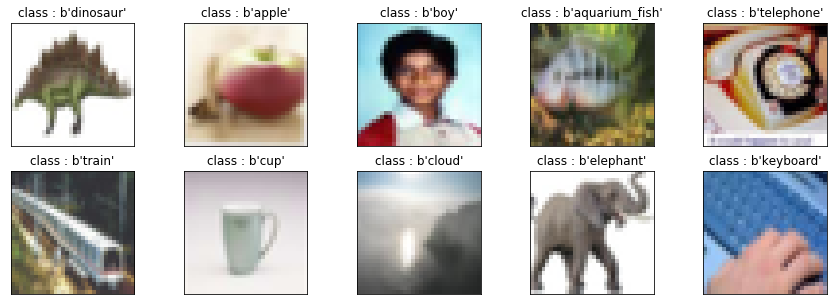

In [5]:
# display sample images
train_rgb = train_raw[b'data'].reshape(len(train_raw[b'data']),3,1024)
print("Data as per RGB channel : {}".format(train_rgb.shape))
test_rgb = test_raw[b'data'].reshape(len(test_raw[b'data']),3,1024)
print("Data as per RGB channel : {}".format(test_rgb.shape))

image_disp = train_raw[b'data'].reshape(len(train_raw[b'data']),3,32,32).transpose(0, 2, 3, 1)
print("RGB Data reshaped for matplotlib display : {}".format(image_disp.shape))

width = 10
height = 10
cols = 5
rows = 2
fig = plt.figure(figsize=(15, 5))

for i in range(1,11):
  plt.subplot(rows, cols, i)
  pixel = image_disp[i]
  image_label = train_raw[b'fine_labels'][i]
  plt.imshow(pixel, cmap=plt.get_cmap('gray'))
  plt.title("class : "  + str(meta_raw[b'fine_label_names'][image_label]) )
  plt.xticks([])
  plt.yticks([])
  
plt.show()

In [6]:
# Fetch Train and Test labels
train_labels = np.asarray(train_raw[b'fine_labels'])
test_labels = np.asarray(test_raw[b'fine_labels'])

print(train_labels.shape)
print(test_labels.shape)

(50000,)
(10000,)


### Image Pre-processing

In [0]:
# Standardise data
def standardize_data(x):
    """
        argument
            - input image data in numpy array [3, 1024]
        return
            - processed image 
    """
    mu = x.mean(0)
    stdv = x.std(0)
    # standard_x = x / 255           # Max division - output range 0 to 1
    # standard_x = (x - mu) / stdv   # Standardise mean and std
    # standard_x = x / stdv          # only by std
    standard_x = x                   # No proprocessing
    return standard_x

X_train = standardize_data(train_rgb)
X_test = standardize_data(test_rgb)

In [8]:
# Using sklearn preprocessing

X_train = X_train.reshape(50000,3072)
X_test = X_test.reshape(10000,3072)

X_train = minmax_scale(train_raw[b'data'], feature_range=(-1,1))
X_test = minmax_scale(test_raw[b'data'], feature_range=(-1,1))

print(X_train.shape, X_test.shape)
# Range after pre-processing
print(max(X_train[:,0]), min(X_train[:,0]))

(50000, 3072) (10000, 3072)
1.0 -1.0


## *Experiment Setup*

In [9]:
# registering time for perfomance measurement
start = time.time()
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

Fri, 08 Nov 2019 08:37:08 +0000


In [10]:
# %%capture cap_out --no-display

# Initialise parameters
batch_size = 32
num_classes = 100

# Reshape Images 
x_train = X_train.reshape(50000,3,32,32).transpose(0, 2, 3, 1)
x_test = X_test.reshape(10000,3,32,32).transpose(0, 2, 3, 1)
# y_train = train_labels
# y_test = test_labels

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Optimiser Selection Function

In [0]:
def get_optimizer(opt, eta):
      if opt == 'amsgrad':
        return keras.optimizers.Adam(lr=eta, decay=1e-6, amsgrad=True)

      if opt == 'rmsprop':
        return keras.optimizers.RMSprop(lr=eta, decay=1e-6)

      if opt == 'adagrad':
        return keras.optimizers.Adagrad(lr=eta, decay=1e-6)

      if opt == 'adadelta':
        return keras.optimizers.Adadelta(lr=eta, decay=1e-6)

      if opt == 'adam':
        return keras.optimizers.Adam(lr=eta, decay=1e-6)

      if opt == 'adamax':
        # return keras.optimizers.Adamax(lr=eta, decay=1e-6)
        return keras.optimizers.Adamax(decay=1e-6)

      if opt == 'nadam':
        return keras.optimizers.nadam(lr=eta)

### Create Model Based on Hyper Parameters Supplied

In [0]:
def create_model(alpha_value, dropout_value, dense_value, loss_type, learning, opt):
      print('''Model params are ::: alpha - {}, 
      dropout - {}, dense - {}, loss - {}, eta - {}, 
      opt - {}'''.format(alpha_value, dropout_value, dense_value, loss_type, learning, opt))

      # create sequential model
      model = Sequential()
      model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
      # model.add(LeakyReLU(alpha=alpha_value))   # Can be changed to prelu, rrelu etc.
      model.add(Activation('elu'))                # Can be changed to 'relu', 'tanh' etc
      model.add(Conv2D(32, (3, 3)))
      # model.add(LeakyReLU(alpha=alpha_value))
      model.add(Activation('elu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Dropout(dropout_value))

      model.add(Conv2D(64, (3, 3), padding='same'))
      # model.add(LeakyReLU(alpha=alpha_value))
      model.add(Activation('elu'))
      model.add(Conv2D(64, (3, 3)))
      # model.add(LeakyReLU(alpha=alpha_value))
      model.add(Activation('elu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Dropout(dropout_value))

      model.add(Conv2D(128, (3, 3), padding='same'))
      # model.add(LeakyReLU(alpha=alpha_value))
      model.add(Activation('elu'))
      model.add(Conv2D(128, (3, 3)))
      # model.add(LeakyReLU(alpha=alpha_value))
      model.add(Activation('elu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Dropout(dropout_value))

      model.add(Flatten())
      model.add(Dense(dense_value))
      # model.add(LeakyReLU(alpha=alpha_value))
      model.add(Activation('elu'))
      model.add(Dropout(dropout_value + 0.05))
      model.add(Dense(num_classes))
      model.add(Activation('softmax'))

      # Compile model
      model.compile(loss=loss_type, 
                    optimizer=get_optimizer(opt, learning),
                    metrics=['accuracy'])
      
      # Convert class vectors to one hot if loss = KL.
      # if(loss_type == "kullback_leibler_divergence"):
      #     y_train = keras.utils.to_categorical(train_labels, num_classes)
      #     y_test = keras.utils.to_categorical(test_labels, num_classes)
      # else:
      #     y_train = train_labels
      #     y_test = test_labels
      
      return model

#### Define Hyper Parameter Grid

In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# set early stopping criteria after which the training will stop
pat = 15
early_stopping = EarlyStopping(monitor='val_acc', patience=pat, verbose=1)

# Set train and test image labels
# y_train = keras.utils.to_categorical(train_labels, num_classes)
# y_test = keras.utils.to_categorical(test_labels, num_classes)
y_train = train_labels
y_test = test_labels

# grid search parameters
alpha_values = [0.3]                            # Tried [0.1, 0.3]
dropout_values = [0.3]                         # Tried [0.25, 0.3, 0.35, 0.4]
dense_values = [512]
loss_types = ["sparse_categorical_crossentropy"]    # ["kullback_leibler_divergence", "sparse_categorical_crossentropy"]
learnings = [0.0005]                            # [0.001, 0.0005, 0.0001] 
opts = ['adamax']                               # ['nadam', 'rmsprop', 'adagrad', 'adadelta']
epoch_values = [100]                            # [15,25,50,100]


param_grid = dict(opt=opts, 
                  learning=learnings, 
                  loss_type=loss_types, 
                  dense_value=dense_values,
                  dropout_value=dropout_values,
                  epochs=epoch_values, 
                  alpha_value=alpha_values)


#### 10-fold cross validation to find best set of hyper parameters

In [66]:
# create model using function call
model = KerasClassifier(build_fn=create_model, verbose=1)

grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=[(slice(None), slice(None))],
                    # cv=3,
                    # n_jobs=-1,
                    verbose=1)

grid_result = grid.fit(x_train, y_train,
                       batch_size=batch_size,
                       shuffle=True,
                       validation_split=0.2,
                       callbacks=[early_stopping],
                       workers=12)

joblib.dump(grid_result, file_path + 'gs_object.pkl')

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Model params are ::: alpha - 0.3, 
      dropout - 0.3, dense - 512, loss - sparse_categorical_crossentropy, eta - 0.0005, 
      opt - adamax


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 13s 326us/step - loss: 3.7287 - acc: 0.1340 - val_loss: 3.1921 - val_acc: 0.2203
Epoch 2/100
40000/40000 [==============================] - 10s 243us/step - loss: 3.1170 - acc: 0.2380 - val_loss: 2.8329 - val_acc: 0.3016
Epoch 3/100
40000/40000 [==============================] - 10s 241us/step - loss: 2.8716 - acc: 0.2879 - val_loss: 2.7245 - val_acc: 0.3259
Epoch 4/100
40000/40000 [==============================] - 10s 243us/step - loss: 2.7385 - acc: 0.3140 - val_loss: 2.5327 - val_acc: 0.3665
Epoch 5/100
40000/40000 [==============================] - 10s 240us/step - loss: 2.6398 - acc: 0.3345 - val_loss: 2.4764 - val_acc: 0.3755
Epoch 6/100
40000/40000 [==============================] - 10s 241us/step - loss: 2.5552 - acc: 0.3505 - val_loss: 2.5187 - val_acc: 0.3778
Epoch 7/100
40000/40000 [==============================] - 10s 241us/step - loss: 2.4720 - acc: 0.3687 - val_l

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.0min finished


Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 13s 329us/step - loss: 3.7452 - acc: 0.1354 - val_loss: 3.3341 - val_acc: 0.2033
Epoch 2/100
40000/40000 [==============================] - 10s 241us/step - loss: 3.1200 - acc: 0.2396 - val_loss: 2.9964 - val_acc: 0.2634
Epoch 3/100
40000/40000 [==============================] - 10s 241us/step - loss: 2.8905 - acc: 0.2831 - val_loss: 2.6556 - val_acc: 0.3330
Epoch 4/100
40000/40000 [==============================] - 10s 242us/step - loss: 2.7533 - acc: 0.3120 - val_loss: 2.4960 - val_acc: 0.3721
Epoch 5/100
40000/40000 [==============================] - 10s 242us/step - loss: 2.6510 - acc: 0.3321 - val_loss: 2.4683 - val_acc: 0.3781
Epoch 6/100
40000/40000 [==============================] - 10s 245us/step - loss: 2.5666 - acc: 0.3472 - val_loss: 2.4053 - val_acc: 0.3949
Epoch 7/100
40000/40000 [==============================] - 10s 242us/step - loss: 2.5025 - acc: 0.3612 - val_l

['/content/drive/My Drive/Colab Notebooks/cifar-100-python/gs_object.pkl']

#### List best parameters and evaluate model

In [67]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(grid_result.cv_results_)

# Score trained model.
scores = grid_result.best_estimator_.model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Best: 0.791420 using {'alpha_value': 0.3, 'dense_value': 512, 'dropout_value': 0.3, 'epochs': 100, 'learning': 0.0005, 'loss_type': 'sparse_categorical_crossentropy', 'opt': 'adamax'}
{'mean_fit_time': array([775.4856472]), 'std_fit_time': array([0.]), 'mean_score_time': array([4.74851346]), 'std_score_time': array([0.]), 'param_alpha_value': masked_array(data=[0.3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_dense_value': masked_array(data=[512],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_dropout_value': masked_array(data=[0.3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_epochs': masked_array(data=[100],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning': masked_array(data=[0.0005],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_loss_type': masked_array(data=['sparse_categorical_crosse

In [68]:
print("--- Total time taken in Training and Validation ---")
print("--- %s sec ---" % (time.time() - start))
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

--- Total time taken in Training and Validation ---
--- 6483.6488156318665 sec ---
Fri, 08 Nov 2019 10:25:12 +0000


### Visualise Best Model

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_179 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_180 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 15, 15, 64)      

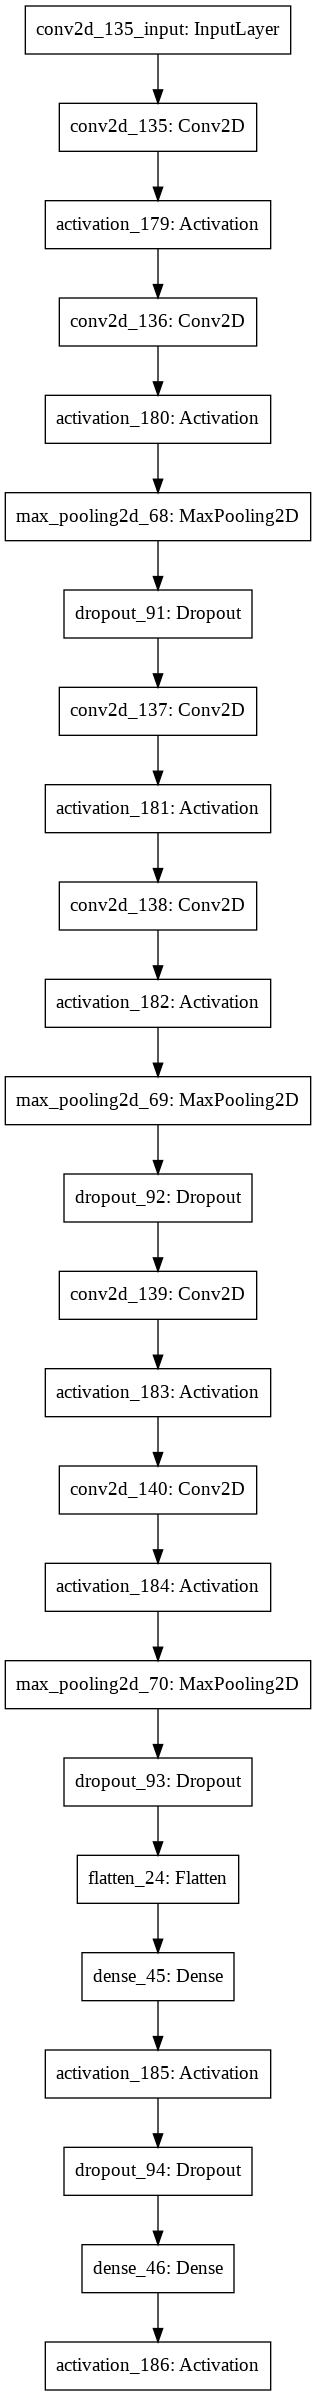

In [70]:
grid_result.best_estimator_.model.summary()

from keras.utils import plot_model
plot_model(grid_result.best_estimator_.model, to_file='model.png')

### Predict Train and Test Labels

In [0]:
# Predictions on train and test set
y_train_preds = grid_result.best_estimator_.model.predict_classes(x_train)
y_test_preds = grid_result.best_estimator_.model.predict_classes(x_test)

In [72]:
y_test_preds.shape

(10000,)

#### Evaluation Metric - *Training* Set

In [73]:
print("-"*80)
print("Evaluation Metric - Training Set")
print("-"*80)

train_accuracy = accuracy_score(train_labels,y_train_preds)
print("\nAccuracy:",train_accuracy)

train_f1_score = f1_score(train_labels,y_train_preds, average = 'weighted')
print("f1_Score:",train_f1_score)

train_precision = precision_score(train_labels,y_train_preds, average = 'weighted')
print("Rrecision:",train_precision)

train_recall = recall_score(train_labels,y_train_preds, average = 'weighted')
print("Recall:",train_recall)

--------------------------------------------------------------------------------
Evaluation Metric - Training Set
--------------------------------------------------------------------------------

Accuracy: 0.78368
f1_Score: 0.7839673294004255
Rrecision: 0.7926460141431552
Recall: 0.78368


#### Evaluation Metric - *Test* Set

In [74]:
print("-"*80)
print("Evaluation Metric - Test Set")
print("-"*80)

test_accuracy = accuracy_score(test_labels,y_test_preds)
print("\nAccuracy:",test_accuracy)

test_f1_score = f1_score(test_labels,y_test_preds, average = 'weighted')
print("f1_Score:",test_f1_score)

test_precision = precision_score(test_labels,y_test_preds, average = 'weighted')
print("Rrecision:",test_precision)

test_recall = recall_score(test_labels,y_test_preds, average = 'weighted')
print("Recall:",test_recall)


--------------------------------------------------------------------------------
Evaluation Metric - Test Set
--------------------------------------------------------------------------------

Accuracy: 0.5162
f1_Score: 0.5130015761595499
Rrecision: 0.5246324307132634
Recall: 0.5162


### Test Set Prediction Heatmap

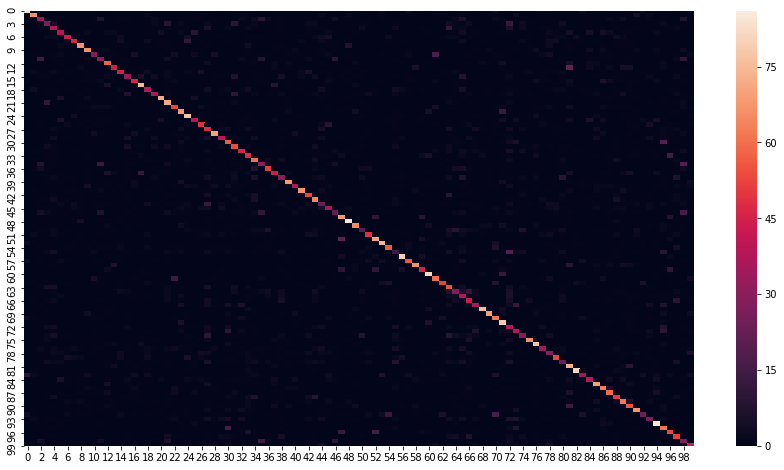

In [75]:
#Check model accuracy, F1 score, Specivity and sensitivity
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

df_cm = confusion_matrix(test_labels,y_test_preds)
df_cm = pd.DataFrame(df_cm)

plt.figure(figsize = (15,8))
sn.heatmap(df_cm)

### Test Set Classification Report

In [76]:
print(classification_report(test_labels,y_test_preds))  

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       100
           1       0.73      0.66      0.69       100
           2       0.40      0.35      0.37       100
           3       0.32      0.26      0.29       100
           4       0.33      0.38      0.35       100
           5       0.48      0.39      0.43       100
           6       0.60      0.43      0.50       100
           7       0.63      0.46      0.53       100
           8       0.71      0.67      0.69       100
           9       0.65      0.66      0.66       100
          10       0.47      0.28      0.35       100
          11       0.33      0.30      0.32       100
          12       0.53      0.58      0.55       100
          13       0.62      0.45      0.52       100
          14       0.57      0.44      0.50       100
          15       0.40      0.32      0.36       100
          16       0.58      0.46      0.51       100
          17       0.68    